# DSM020 CW2: Judging a book by its synopsis

## Background

In the world of book retailing, the task of categorising new books correctly is vital to maximising both audience reach and sales.  Poor classification
could misrepresent the book’s content in its metadata and not only impact its in-store shelve location but also its chances of being surfaced correctly in online searches and recommendations. 

In the UK it’s generally left to the author or the publisher to categorise a book manually by following the guidelines of the Book Industry Communication (BIC) categorisation system (BIC and Nielsen Book Services Ltd, 2010). Such a task needs to consider how to treat a book’s subject matter amongst many of BIC’s 19 categories and dozens of various sub-categories.  

By considering NLP techniques to manipulate text data and machine learning algorithms to fit models to the transformed data it may be possible to create an accurate classifier tool which could remove this manual process. A quick literature search using Summon shows that there are many such use cases.  I propose to undertake my own use case, a proof of concept, using book metadata captured from a High street retailer.
 
This notebook details the approach taken to building such a classification model.

## Contents

01. Objective
02. Methodology
03. Git repository
04. Notebook set-up
05. Data extraction & preparation
06. Exploratory data analysis
07. Classifier models
     - Using a n-grams as model features
     - Using TF-IDF weights as model features
     - Using a pre-trained word embedding model
08. Summary of results & conclusion
09. References
10. Create requirements.txt

## 1. Objective

The exploratory data analysis presented in my proposal for CW1 provided evidence that there is differentiation in the aggregate vocabularies. From this there is reason to believe that a model with good discriminating power could be built to successfully classify new books into their correct subject categories with a good degree of confidence.

Thus the objective of this project is to build a book classification model as a proof of concept which could be considered by book cataloguers if successful. Different approaches and tools will be used to find a champion model. 

## 2. Methodology

A short literature review using the University of London’s Library search engine Summon and Google shows a typical approach to classifying documents using NLP techniques typically involves the four stages of:

#### i.  Feature extraction (including pre-processing)

In CW1 I extracted and pre-processed the data so that the data is ready for tokenisation and thus feature creation. I re-ran this stage as part of CW2 to increase my dataset size - see section (5) below. I will try three types of tokenisation in order of sophistication and benefit: 

      a. n-grams                       - none/some consideration of word order
      b. TF-IDF                        - considers popularity of token within a category & across all other categories
      c. Text embeddings               - semantic approach where each token has its context (‘sense’) interpreted correctly 

#### ii.  Dimension reduction

As a feature matrix in NLP can be very large and sparse there is risk of overfitting of the model and thus not generalising well to new data (Gupta et al, 2019).  A traditional method like Principle Component Analysis or a more modern method like auto encoding can be applied to reduce the dimensions of the feature space significantly. Due to time limitations and inexperience with these concepts I did not pursue dimension reduction in my methodology. 

#### iii.  Classification techniques

       a. Support Vector Machine                - used to fit a model to features created by n-grams and TF-IDF
       b. Transfer learning from TensorFlow Hub - a pre-trained word embedding model 

#### iv.	 Evaluation

The best model will be assessed on different metrics produced by the relevent Python/TensorFlow packages such as:

       a. Accuracy
       b. Precision
       c. Recall
       d. F1-score
       e Classification matrix

Evaluation is undertaken independently on a portion of the data which the models were not trained with.

(Parilkumar et al 2021; Kowsari et al, 2019; Ozsarfati et al, 2019; Gupta et al, 2019; Baygin, 2018)

## 3. Git repository

Git was used to manage version control for this project. All code, data and documentation for this project is available publicly on the Github repository as:

https://github.com/jm-training/DSM020-CW2


## 4. Notebook setup

In [552]:
#!pip install yellowbrick

import pandas as pd
import numpy as np   
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud 
from yellowbrick.classifier import ClassificationReport
import nltk
import string
translator=str.maketrans(string.punctuation, ' '*len(string.punctuation)) # Map any punctuation characters to white space
from scipy.spatial import distance_matrix
import tensorflow as tf
import tensorflow_hub as hub
import requests
import warnings

## 5. Data extraction & preparation

Further study since the completion of CW1 has drawn my attention to the need to use a larger dataset for deep learning models to help avoid overfitting and poor generalization on unseen data (Zafra, 2019). With this in mind, particularly for the application of deep learning models in the TensorFlow Hub I have extracted four times as many books as originally extracted and then prepared this data, analogous to CW1, with the following steps:

    a. Clean text features    - remove superfluous characters from strings
    b. Clean numeric features - check they are not corrupted with alphabetical characters & of the required length
    c. Treat missing values   - populate missing synopses using other online data sources
    d. Split synopsis into individual words (tokens) & remove redundant words with stop word application
    e. Lemmatize words        - using WordNet lemmatizer
    f. Remove outliers        - remove synopses shorter than required threshold of words
    g. Remove books assigned to more than one subject category

The code to do the extraction and data preparation steps is 'DSM020 CW2 - Data extraction' and is derived from the code created for CW1 and can be found at http://localhost:8888/notebooks/DSM-020/5.%20CW2/GitHub-Repo/DSM020%20CW2%20-%20Data%20extraction.ipynb. Ideally even more data would have been extracted but I had to balance ethical and practical considerations. Increasing the amount of data to be extracted by a factor of four increased the processing time so significantly that greater levels would have been impractical.

After applying these cleaning and preparation stages the new dataset 'all_16_clean' comprises 2,598 books compared to the original dataset 'all1' after the same stages with 656 books  

## 6. Exploratory data analysis

### a. Distribution of books by subject category

The distributions of the number of books by subject category are the same for both the revised and original datasets (see below). Importantly the revised dataset contains approximately the same proportion of books per subject category so we can consider it as a 'balanced' dataset. An imbalanced dataset will have a skew towards some subject categories meaning a model trained on such data will have a bias towards those subject categories with more books (Gandler, 2020).

In [387]:
df_old=pd.read_csv("all1.csv", index_col=0).reset_index()
df_new=pd.read_csv("all_16_clean.csv", index_col=0).reset_index()
old=df_old.Subject.value_counts(dropna=False).reset_index()
new=df_new.Subject.value_counts(dropna=False).reset_index()
both=pd.merge(old, new, on=['index'])
both.rename(columns = {'Subject_x':'Original no. books', 'Subject_y':'Revised no. books', 'index':'Subject category'}, inplace = True)
both.sort_values(by='Revised no. books', ascending=False, inplace=True)

old1=df_old.Subject.value_counts(dropna=False, normalize=True).reset_index()
new1=df_new.Subject.value_counts(dropna=False, normalize=True).reset_index()
both1=pd.merge(old1, new1, on=['index'])
both1.rename(columns = {'Subject_x':'Original % books', 'Subject_y':'Revised % books', 'index':'Subject category'}, inplace = True)
both1.sort_values(by='Revised % books', ascending=False, inplace=True)

combined=pd.merge(both, both1, on=['Subject category'])
combined1=combined[['Subject category', 'Original no. books','Original % books','Revised no. books','Revised % books']]
for i in ['Original % books','Revised % books']:
    combined1[i] = combined1[i].astype(float).map("{:.0%}".format)
combined1

,Subject category,Original no. books,Original % books,Revised no. books,Revised % books
0,romantic fiction,92,14%,363,14%
1,history,91,14%,355,14%
2,food drink,88,13%,345,13%
3,sports leisure,89,14%,335,13%
4,entertainment,79,12%,321,12%
5,spirituality beliefs,75,11%,305,12%
6,science technology medicine,72,11%,294,11%
7,business finance law,70,11%,280,11%


### b. Variation in vocabularies across the subject categories

Given this larger dataset I want to check if there has been a change in the variation in the vocabularies across the eight subject categories. A quick check of the top words (unigrams) in terms of frequency via word clouds and the derivation of a distance matrix shows the larger corpus is still very similar to the original one in terms of top words. The subject categories of 'spirituality beliefs', 'science technology medicine' and 'business finance law' are still as similar as before.

For practical reasons the code below used to create the word clouds and distance matrices for the revised dataset is that of CW1.

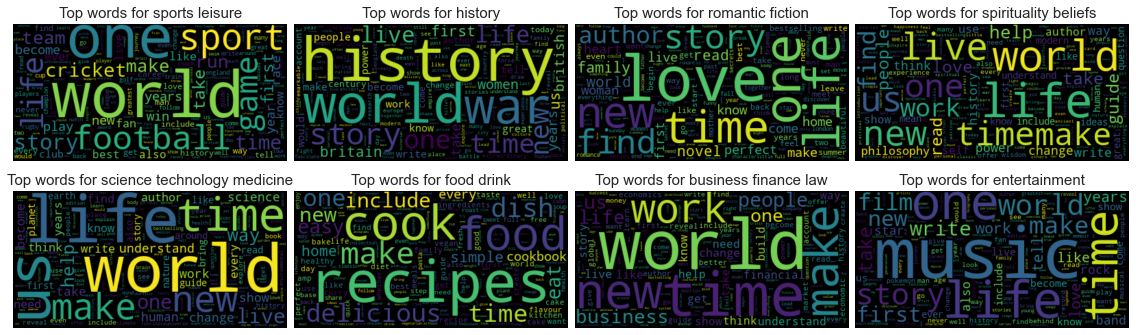

In [216]:
# Prepare data

df3=df_new.copy()

# Get number of books per subject
book_count=df3.groupby('Subject').size()
book_count1 = pd.DataFrame(book_count).reset_index()
book_count1.columns = ['Subject', 'No. books']
book_count1.sort_values(by='No. books', ascending=False, inplace=True)

# Get number of words per subject
subjects=['sports leisure','history','romantic fiction','spirituality beliefs','science technology medicine', 'food drink',
'business finance law','entertainment']
dic0={}
dic1={}
dic={}
for i in subjects:
    # Get all synopses of subject category
    words=df3['Synopsis2'][df3['Subject']==i]
    # Join together into one string
    words1=''.join(''.join(sub) for sub in words)
    # Remove punctuation from string
    words2=words1.translate(translator)
    # Convert to list of words
    words3=words2.split()
    dic0[i]=words3
    # Get count of unique words per subject
    dic[i]=len(set(words3))
    # Get frequency counts of words per subject
    words4 = nltk.FreqDist(words3)
    words5=dict(words4)
    # Create word cloud objects
    wcloud=WordCloud().generate_from_frequencies(words5)
    dic1[i]=wcloud
    
# Plot Word Clouds
values = list(dic1.values())
plt.figure(figsize = (20,6))
gs1 = gridspec.GridSpec(2, 4)
gs1.update(wspace=0.025, hspace=0.05)
for i in range(8):
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(values[i], interpolation="bilinear")
    ax1.set_title("Top words for "+str(subjects[i]),fontsize=15)
    ax1.set_aspect('equal')
plt.show()

Word clouds of the original dataset:

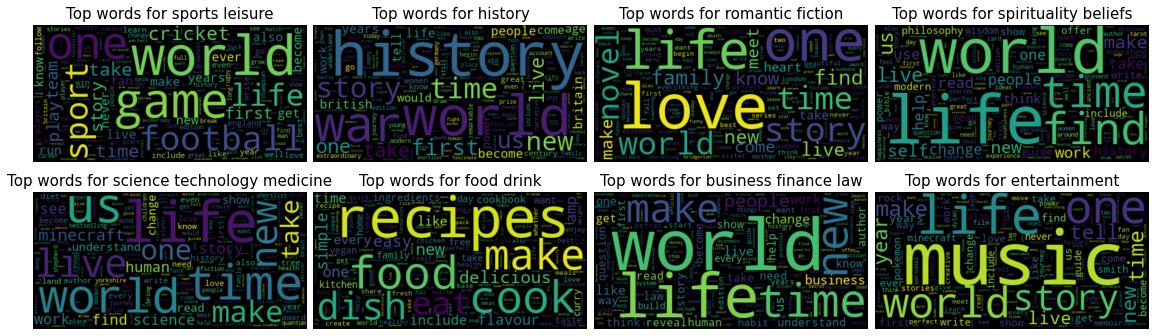

The heatmaps below show the Euclidean distances between each subject category based on vector space calculations. The smaller the distances between subject categories the higher the similarity. As found in CW1 there are still larger differences in distances between the diverse subjects like 'food drink' and 'entertainment' meaning their vocabularies are differ more noticeably. And as per the word clouds the distance matrix confirms the pairwise combinations of 'spirituality beliefs', 'science technology medicine' & 'business finance law' having the most similar vocabularies out of the 8 subject categories.

In [227]:
# Get data
spor=' '.join(dic0['sports leisure'])
hist=' '.join(dic0['history'])
roma=' '.join(dic0['romantic fiction'])
spir=' '.join(dic0['spirituality beliefs'])
scie=' '.join(dic0['science technology medicine'])
food=' '.join(dic0['food drink'])
busi=' '.join(dic0['business finance law'])
ente=' '.join(dic0['entertainment'])
all=[spor,hist,roma,spir,scie,food,busi,ente]

# Create distance matrix
with warnings.catch_warnings():
    # Ignore warning for this code
    warnings.filterwarnings("ignore")
    cv = CountVectorizer(all)
    words=cv.fit_transform(all)

words=words.toarray()
words.shape
#(8, 11558)

dist_matrix=distance_matrix(words,words)
dist_matrix_df=pd.DataFrame(dist_matrix, index=subjects,columns=subjects).astype(int)
#dist_matrix_df

The revised distance matrix:


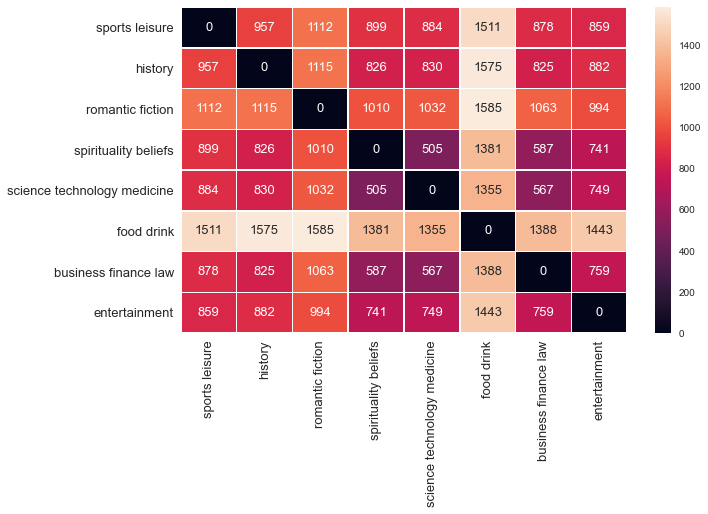

In [392]:
# Create distance heat map
print("The revised distance matrix:")
fig, ax = plt.subplots(figsize=(10,6))   
ax = sns.heatmap(dist_matrix_df, linewidth=0.5, annot=True, annot_kws={"size": 13}, fmt='d', xticklabels=subjects, yticklabels=subjects)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 13)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 13)
plt.show()

The original distance matrix:

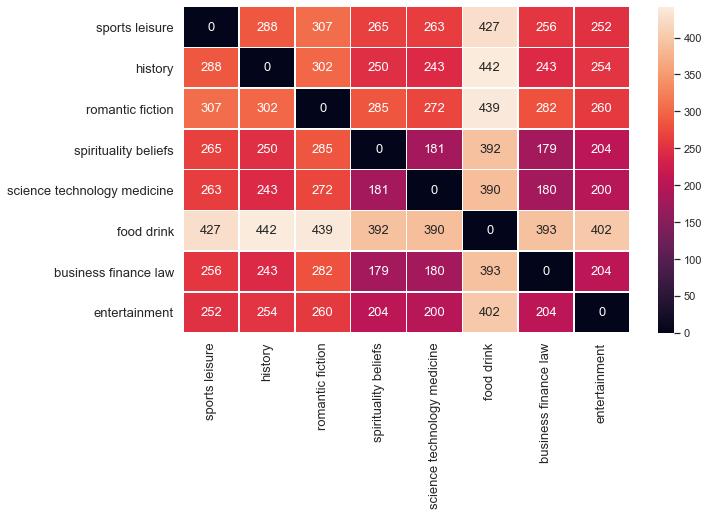

## 7. Classifier models

My literature review highlights many classification algorithms, from the simplest technique of Naïve Bayes through traditional approaches like decision trees and logistic regression, boosted and bagging techniques and into deep learning models like Long Short-Term Memory Neural Networks (LSTM).  A similar piece of work to mine (Parilkumar et al, 2021) which also sought to classify books by genre and used TF-IDF as the features. This study compared the three techniques of k-nearest neighbours (KNN), Support Vector Machines (SVM) and logistic regression and concluded that SVM provided the best results and was the most efficient algorithm. Another two studies that sought to classifying books by only their titles showed that LSTM provides the best performance (Ozsarfati et al, 2019; Ng, 2020). LSTM has the ability to keep a memory of words early in a sentence which helps give the whole sentence more meaning. There is a trade-off between interpretability and accuracy of results when comparing algorithms, with traditional algorithms being more interpretable but less accurate than contemporary deep learning algorithms (Kowsari et al, 2019).

Like the study of Parilkumar et al I will use Scikit-Learn's SVM for as a classifer on the features built firstly as uni- and bigrams and the second on features built as TF-IDF weights. Lastly I will try a pre-trained word embedding approach from TensorFlow Hub which maps the text from each book into 128 dimensional embedding vectors and then classification is undertaken using a 'feed-forward Neural-Net Language' Model (Google, 2021)

Not being a practioner of machine learning modelling for this section I was guided by these three online resources:
- TowardsDataScience ('https://towardsdatascience.com/text-classification-in-python-dd95d264c802')
- DataCamp (https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)
- geeksforgeeks (https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/) 

### a. Using n-grams as model features

A simple approach like unigrams (1-grams) considers each word as a token and its frequency is used in the feature vector. Where n>1 the n-gram approach creates tokens from n consecutive words instead.  While the unigrams approach does not consider the order of words the n-grams (where n>1) does.  For example, the two-grams of the sentence "John likes to watch movies. Mary likes movies too", tells us that the word ‘likes’ comes after a person’s name (Wikipedia, 2021) which would not happen with the unigram approach.  

The approach chosen considers a mix of n-grams (1-grams, 2-grams & 3-grams) as it is possible that different sized n-grams will optimize the model. 

#### i. Prepare data

The model requires that the subject category, which is the target variable, be converted from a string into an integer

In [504]:
# Keep finalised synopsis and target (='Subject')
df=pd.read_csv("all_16_clean.csv", index_col=0, usecols=['Synopsis2','Subject']).reset_index() 

In [505]:
# Use LabelEncoder to transform categorical labels to integer labels
encoder=preprocessing.LabelEncoder()
encoder.fit(df.Subject)
df['Subject1']=encoder.transform(df.Subject)

#### ii. Find optimal model

Using the online resources of:

 - TowardsDataScience ('https://towardsdatascience.com/text-classification-in-python-dd95d264c802')
 - DataCamp (https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)
 - geeksforgeeks (https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/) 

the approach for building the optimal SVM model requires optimising two sets of paramaters - those of the n-grams and the hyperparameters of SVM (C, gamma & kernel). The code below runs through two grids containing a range of parameters to find the optimal model. 

In [506]:
########## Split data into training & validation ##########

train, valid = train_test_split(df, test_size=0.20, random_state=42)

In [507]:
########## Build models ##########

def optimal_ngram_model(train, valid, ngram_range, min_df, max_df, max_features):
    '''
    This function creates a SVM model for ngram parameters received from the function best_ngram_model()
    It then optimises the model's SVM hyperparameters and passes back the optimised model to best_ngram_model()
    '''
    # Design the Bag of Words Vectorizer 
    # Note that the default setting in this function skips the tokenisation process as data is already tokenised
    ngram = CountVectorizer(ngram_range=ngram_range,
                          min_df=min_df,
                          max_df=max_df,
                          max_features=max_features)
    
    # Support Vector Machine hyperparameter grid
    grid = {'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': [.0001, .001, .01, .1, 1, 10]}
    
    # Use Vectorizer to transform the training and test data into Bag of Words' weights
    train_t = ngram.fit_transform(train['Synopsis2']).toarray()
    valid_t = ngram.transform(valid['Synopsis2']).toarray()
    
    # Instantiate the SVC model using GridSearch
    model = GridSearchCV(SVC(), grid, refit = True)
  
    # Fit the model to training data
    model1 = model.fit(train_t, train['Subject1'])
    
    # Get best model hyperparameters after tuning
    best_paramaters=model1.best_params_
     
    # Score the validation data based on best hyperparameters      
    valid_pred = model1.predict(valid_t)
          
    # Calculate model accuracy based on validation data
    valid_accuracy=accuracy_score(valid['Subject1'], valid_pred)
          
    return best_paramaters, valid_accuracy, model1

def best_ngram_model(train, valid):
    '''
    This function passes iterations of n-gram parameters to the optimal_ngram_model() function above 
    For each set of n-gram parameters passed up it receives back an optimised SVC model 
    It then finds the best model based on the performance metric of accuracy
    '''
    # n-gram criteria
    ngram_range=[(1, 2), (2,3)]     # Range of n-grams to be used in feature creation e.g. (1,3) = 1-, 2- & 3-grams are created
    min_df=[1, 5, 10]               # Ignore terms that have a document frequency strictly lower than nominal value X
    max_df=1.0                      # Maximum document frequency set to 100% to not ignore any other words
    max_features=[500, 1000, 1500]  # Use the top X features based on frequency count across all books
    
    # Run all models as per n-gram criteria
    history={}
    i=0
    for j in ngram_range:
        for k in min_df:
            for l in max_features:
                i=i+1
                # Build optimal SVM model using above functions
                history[i]=optimal_ngram_model(train, valid, j, k, max_df, l), j, k, l
                      
    # Identify best model in terms of overall accuracy
    count=len(ngram_range)*len(min_df)*len(max_features)
    accuracy=0
    model=0
    for i in range(1,count+1):
        if history[i][0][1]>=accuracy:
            model=i
            accuracy=history[i][0][1]
            svm_params=history[i][0][0]
            ngram_ngram_range=history[i][1]
            ngram_min_df=history[i][2]
            ngram_max_df=1.0
            ngram_max_features=history[i][3]
    print("Model "+str(model)+" is best") 
    print("SVM hyperparameters:")
    print("    ",svm_params)
    print("")
    print("Accuracy =",accuracy)
    print("Vectorizer parameters:")
    print("     ngram_range =",ngram_ngram_range)
    print("     min_df =",ngram_min_df)
    print("     max_df =",ngram_max_df)    
    print("     max_features =",ngram_max_features)
    
    return history, history[model]

In [508]:
########## Get parameters of best model ##########

all_models, best_model=best_ngram_model(train, valid)

Model 3 is best
SVM hyperparameters:
     {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}

Accuracy = 0.6742424242424242
Vextorizer parameters:
     ngram_range = (1, 2)
     min_df = 1
     max_df = 1
     max_features = 1500


#### iii. Evaluate optimal model

Once the optimal model has been found it needs to be evaluated on the validation data.  Several metrics are used to do this and they are all easily accessed using Scikit-learn:

- Accuracy:               Proportion of all books that the model correctly assigns to subjects  
- Precision:              Proportion of books that the model assigns to a subject and are correct
- Recall:                 Proportion of books in a subject that the model assigns correctly
- F1-Score:               Harmonic mean between recall & precision values. A score of 1.0 indicates perfect precision & recall
- Support:                Number of books actually in a subject
- Classification matrix:  Number of books assigned correctly or incorrectly to each subject category


Validation accuracy:

0.6742424242424242

Classification report:



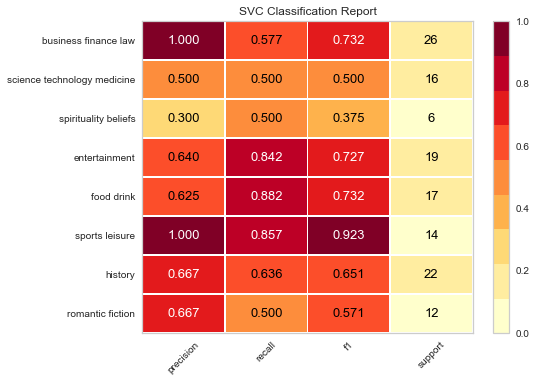

Classification matrix:


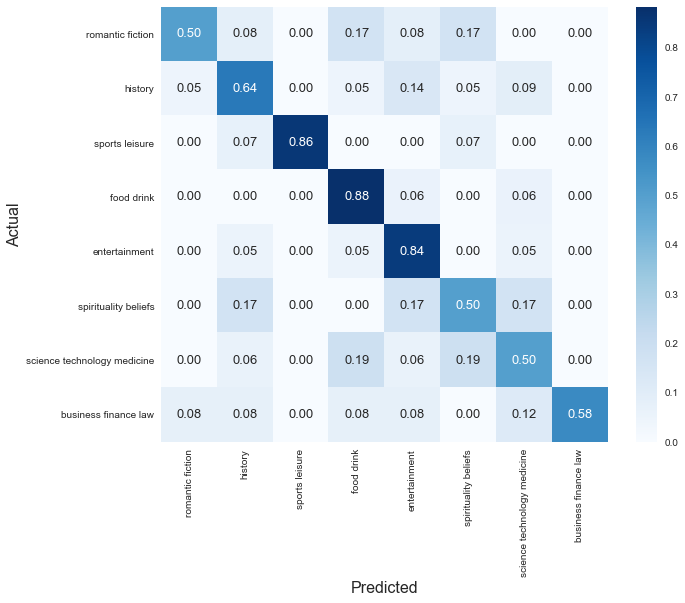

In [510]:
########## Output required metrics ##########

def get_preds(train, 
              ngram_range, 
              min_df, 
              max_df, 
              max_features, 
              C, 
              gamma, 
              kernal):
    '''
    This function builds the best model based on optimised parameters found above and then scores the validation data
    - classifying each of its books into a subject category
    '''
    # Use Vectorizer to transform the training and validation data using optimal Bag of Words parameters
    ngram = CountVectorizer(ngram_range=ngram_range,
                            min_df=min_df,
                            max_df=max_df,
                            max_features=max_features)
    
    # Use Vectorizer to transform the training and test data into Bag of Words weights
    train_t = ngram.fit_transform(train['Synopsis2']).toarray()
    valid_t = ngram.transform(valid['Synopsis2']).toarray()
    
    # Create finalised model using optimal parameters
    model=svm.SVC(C=C,gamma=gamma, kernel=kernal)
   
    # Train the model using the transformed BoWs training data
    model.fit(train_t, train['Subject1'])
    
    # Predict the subject categories for validation datasets
    valid_preds = model.predict(valid_t)   

    return valid_preds, model

def class_matrix(act, pred, labels):
    '''
    This function creates a classification matrix based on actual and predicted subject categories for each book in the 
    validation data
    '''
    # Create the subject assignment breakdown
    cm = confusion_matrix(act, pred)
    # Convert assignment counts into assignment percentages of each subject (calculate across the rows)
    cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots(figsize=(10,8))
    plt.rcParams.update({'font.size': 13})
    sns.heatmap(cmp, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual', size=16)
    plt.xlabel('Predicted', size=16)
    return plt.show(block=False)
    
def eval_model(valid_preds, model):
    '''
    This function calls the above two functions to print out all of the required evaluation metrics
    '''
    # Overall accuracy
    print("\033[1m"+"Validation accuracy:"+"\033[0m")
    print()
    print(accuracy_score(valid['Subject1'], valid_preds))
    print()
    # Classification report (here use Yellowbrick classification report module)
    print("\033[1m"+"Classification report:"+"\033[0m")
    print()
    classes = ['romantic fiction',
               'history',
               'sports leisure',
               'food drink',
               'entertainment',
               'spirituality beliefs',
               'science technology medicine',
               'business finance law']
    visualizer = ClassificationReport(model, classes=classes, support=True) # Instantiate the visualizer
    visualizer.fit(train_t, train['Subject1'])                              # Fit visualizer using pre-fitted model from above
    visualizer.score(valid_t, valid['Subject1'])                            # Get classification assignments for validation data
    visualizer.show()  
    # Classification matrix
    print("\033[1m"+"Classification matrix:"+"\033[0m"),
    subjects=['romantic fiction',
          'history',
          'sports leisure',
          'food drink',
          'entertainment',
          'spirituality beliefs',
          'science technology medicine',
          'business finance law']
    class_matrix(valid['Subject1'],valid_preds, subjects)
    return model

# Get parameters of best model
c=best_model[0][0]['C']
gamma=best_model[0][0]['gamma']
kernel=best_model[0][0]['kernel']
ngram_range=best_model[1]
min_df=best_model[2]
max_df=1.0
max_features=best_model[3]

# Get predictions based on best model
valid_preds, model=get_preds(train, 
                             ngram_range, 
                             min_df, 
                             max_df, 
                             max_features, 
                             c, 
                             gamma, 
                             kernal)

# Get evaluation metrics
model=eval_model(valid_preds, model)

The results for a SVM model using both 1-grams and 2-grams are promising and provide a good baseline to start with.

- The overall validation dataset accuracy is 67% meaning that 67% of books in the validation data have been classified correctly into their subject category. 
- Looking at the classification matrix we see that the subject categories of 'food drink', 'sport leisure' and 'entertainment' have high rates of successful classification while others are less so successful with around a half being correctly assigned. 
- Interestingly, 19% of books in 'science technology medicine' are being assigned to 'food drink'
- While 'business finance law' has only a 58% rate of successful assignment it has a 100% precision rate which means by design it is producing no false positives but a lot of false negatives 

### b. Using Term Frequency-Inverse Document Frequency (TF-IDF) weights as model features

Instead of simple frequency counts being used for n-grams as the feature matrix the TF-IDF approach advantagously transforms the n-grams. It normalizes n-gram counts by considering their relative importance within a book as well as across all the books in the dataset.
 
- It also enables features to be created which are not skewed because of different synopsis lengths. 
- As TF-IDF transforms the n-grams they in turn can be tuned

#### i. Prepare data

The model requires that the subject category, which is the target variable, be converted from a string into an integer

In [514]:
df=pd.read_csv("all_16_clean.csv", index_col=0, usecols=['Synopsis2','Subject']).reset_index() 

In [515]:
# Use LabelEncoder to transform categorical labels to integer labels
encoder=preprocessing.LabelEncoder()
encoder.fit(df.Subject)
df['Subject1']=encoder.transform(df.Subject)

#### ii. Find optimal model

In [516]:
########## Split data into training & validation ##########

train, valid = train_test_split(df, test_size=0.20, random_state=42)

In [518]:
########## Build models ##########

def optimal_tfidf_model(train, valid, ngram_range, min_df, max_df, max_features):
    '''
    This function creates a SVM model for TF-IDF parameters received from the function best_tfidf_model()
    It then optimises the model's SVM hyperparameters and passes the optimised model back to best_tfidf_model()
    '''
    # Design the TF-IDF Vectorizer 
    # Note that the default setting in this function skips the tokenisation process as data is already tokenised
    tfidf=TfidfVectorizer(ngram_range=ngram_range,  # Range of n-grams to be used in feature creation e.g. (1,3) = 1-,2- & 3-grams are created    
                          min_df=min_df,            # Ignore terms that have a document frequency strictly lower than nominal value X
                          max_df=max_df,            # Ignore terms that have a document frequency strictly higher than X%
                          max_features=max_features,# Use the top X features based on frequency count across all books
                          sublinear_tf=True)        
    
    # Support Vector Machine hyperparameter grid
    grid = {'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': [.0001, .001, .01, .1, 1, 10]}
    
    # Use the Vectorizer to transform the training and test data into TF-IDF weights
    train_t = tfidf.fit_transform(train['Synopsis2']).toarray()
    valid_t = tfidf.transform(valid['Synopsis2']).toarray()
    
    # Instantiate the SVC model using GridSearch
    model = GridSearchCV(SVC(), grid, refit = True)
  
    # Fit the model to training data
    model1 = model.fit(train_t, train['Subject1'])
    
    # Get best model hyperparameters after tuning
    best_paramaters=model1.best_params_
     
    # Score the validation data based on best hyperparameters      
    valid_pred = model1.predict(valid_t)
          
    # Calculate model accuracy based on validation data
    valid_accuracy=accuracy_score(valid['Subject1'], valid_pred)
          
    return best_paramaters, valid_accuracy, model1

def best_tfidf_model(train, valid):
    '''
    This function passes iterations of TF-IDF parameters to the optimal_tfidf_model() function above 
    For each set of TF-IDF parameters passed up it receives back an optimised SVC model
    It then finds the best model based on the performance metric of accuracy
    '''
    # TF-IDF criteria
    ngram_range=[(1, 2), (2,3)]     # Range of n-grams to be used in feature creation e.g. (1,3) = 1-, 2- & 3-grams are created
    min_df=[1, 5, 10]               # Ignore terms that have a document frequency strictly lower than nominal value X
    max_df=1.0                      # Maximum document frequency set to 100% to not ignore any other words
    max_features=[500, 1000, 1500]  # Use the top X features based on frequency count across all books
    
    # Run all models as per TF-IDF criteria
    history={}
    i=0
    for j in ngram_range:
        for k in min_df:
            for l in max_features:
                i=i+1
                # Build optimal SVM model using above functions
                history[i]=optimal_tfidf_model(train, valid, j, k, max_df, l), j, k, l
                      
    # Identify best model in terms of overall accuracy
    count=len(ngram_range)*len(min_df)*len(max_features)
    accuracy=0
    model=0
    for i in range(1,count+1):
        if history[i][0][1]>=accuracy:
            model=i
            accuracy=history[i][0][1]
            svm_params=history[i][0][0]
            tfidf_ngram_range=history[i][1]
            tfidf_min_df=history[i][2]
            tfidf_max_df=1.0
            tfidf_max_features=history[i][3]
    print("Model "+str(model)+" is best") 
    print("SVM hyperparameters:")
    print("    ",svm_params)
    print("")
    print("Accuracy =",accuracy)
    print("Vectorizer parameters:")
    print("     ngram_range =",tfidf_ngram_range)
    print("     min_df =",tfidf_min_df)
    print("     max_df =",tfidf_max_df)                # Was incorrectly coded as max_df =",tfidf_min_df
    print("     max_features =",tfidf_max_features)
    
    return history, history[model]

In [519]:
########## Get parameters of best model ##########

all_models, best_model=best_tfidf_model(train, valid)

Model 9 is best
SVM hyperparameters:
     {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Accuracy = 0.7196969696969697
Vextorizer parameters:
     ngram_range = (1, 2)
     min_df = 10
     max_df = 10
     max_features = 1500


Note that the max_df is actually 1.0 and not 10, the code above incorrectly had max_df=",bow_min_df". 
Hence the need to manual enter the paramters below in the build of the optimal model

#### iii. Evaluate optimal model

In [554]:
########## Get optimal model using optimal TF-IDF & SVM hyperparameters ##########

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        min_df=10,
                        max_df=1.0,
                        max_features=1500,
                        sublinear_tf=True)

# Use Vectorizer to transform the training and test data into Bag of Words weights
train_t = tfidf.fit_transform(train['Synopsis2']).toarray()
valid_t = tfidf.transform(valid['Synopsis2']).toarray()

# Create finalised model using optimal parameters
model=svm.SVC(C=10,gamma=1, kernel='rbf')

# Train the model using the transformed BoWs training data
model.fit(train_t, train['Subject1'])

# Predict the subject categories for validation datasets
valid_preds = model.predict(valid_t)   

Validation accuracy:

0.7196969696969697

Classification report:

              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.78      0.64      0.70        22
           2       1.00      0.86      0.92        14
           3       0.57      1.00      0.72        17
           4       0.78      0.95      0.86        19
           5       0.42      0.83      0.56         6
           6       0.78      0.44      0.56        16
           7       0.94      0.62      0.74        26

    accuracy                           0.72       132
   macro avg       0.73      0.73      0.70       132
weighted avg       0.77      0.72      0.72       132


Classification matrix:


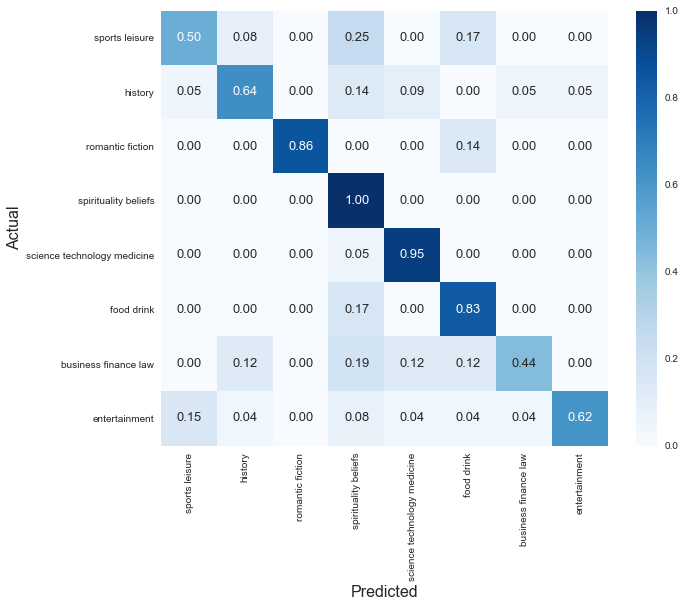

In [561]:
########## Get evaluation statistics ##########

# Overall accuracy
print("\033[1m"+"Validation accuracy:"+"\033[0m")
print()
print(accuracy_score(valid['Subject1'], valid_preds))
print()
# Other metrics
print("\033[1m"+"Classification report:"+"\033[0m")
print()
print(classification_report(valid['Subject1'], valid_preds))
print()
# Confusion matrix
print("\033[1m"+"Classification matrix:"+"\033[0m"),
class_matrix(valid['Subject1'],valid_preds,subjects)

The results for a SVM model using TF-IDF transformed n-grams performs even better than the that just using n-grams as features.

- The overall validation dataset accuracy has increased from 67% for the previous model to 72% with this revised model
- Looking at the classification matrix we see that the successful classification rates have increased for most subject categories. Now 'spirituality beliefs', 'science technology medicine' and 'food drink' have the highest rates of successful classification. The lowest rate is 44% for 'business finance law' 

### C. Using a pre-trained word embedding model

Here a pre-trained word embedding (trained on English Google News 200B corpus) which was built using NNLM with three layers is applied onto the raw text data as such an approach does not require text preprocessing 

The work embedding comprises 50 dimensions and is normalised (cf. Google, 2021. [online] at https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) 

The model applied is Keras sequential model which comprises layers

For this section I was guided by the documentation available from the TensorFlow Hub (cf. TensorFlow Hub, 2021, [online] at https://www.tensorflow.org/tutorials/keras/text_classification_with_hub)

#### i. TensorFlow environment

In [484]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


#### ii. Data preprocessing

In [485]:
########## Import data ##########

df=pd.read_csv("all_16_clean.csv", index_col=0, usecols=['Synopsis','Subject']).reset_index()  # all_16_clean.csv

In [486]:
########### Create the required subsets of data of model build and evaluations ##########

train, valid = train_test_split(df, test_size=0.30, random_state=42)

In [487]:
########### Create Tensor slices ###########

train1 = tf.data.Dataset.from_tensor_slices((train['Synopsis'].values, train['Subject'].values))
valid1 = tf.data.Dataset.from_tensor_slices((valid['Synopsis'].values, valid['Subject'].values))

In [488]:
# Review an example of tensor data - the synopses have not been processed in any way

train_example_synopsis, train_example_subject = next(iter(train1.batch(1)))
print(train_example_synopsis, train_example_subject)

tf.Tensor([b'for curious readers young and old a rich and colorful history of religion from humanity s earliest days to our own contentious times in an era of hardening religious attitudes and explosive religious violence this book offers a welcome antidote richard holloway retells the entire history of religion from the dawn of religious belief to the twenty first century with deepest respect and a keen commitment to accuracy writing for those with faith and those without and especially for young readers he encourages curiosity and tolerance accentuates nuance and mystery and calmly restores a sense of the value of faith ranging far beyond the major world religions of judaism islam christianity buddhism and hinduism holloway also examines where religious belief comes from the search for meaning throughout history today s fascinations with scientology and creationism religiously motivated violence hostilities between religious people and secularists and more holloway proves an empathic

In [489]:
########### One hot encode the categorical target labels for NN processing ############

# Note this section of code was adapted from that created by AIEngineering found online at 
# https://www.youtube.com/watch?v=dkpS2g4K08s

# Create a immutable look-up table that can be referred to in one hot encoding (OHE) process
table = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(
                                  keys=tf.constant(['romantic fiction','history','sports leisure','food drink','entertainment',
                                                    'spirituality beliefs','science technology medicine',
                                                    'business finance law']), 
                                  values=tf.constant([0,1,2,3,4,5,6,7])),
                                  default_value=tf.constant(-1),
                                  name="target_encoding")

@tf.function
def target(x):
  return table.lookup(x)

# Define OHE function to transform the lable's 1-d representation to an 8-d array representation 
# (8 being the number of unique labels)
def fetch(text, labels):
  return text, tf.one_hot(target(labels),8)

# Undertake OHE on each element in the tensor slides
train2=train1.map(fetch)
valid2=valid1.map(fetch)

In [490]:
# Review example of a transformed target label
next(iter(train2))

(<tf.Tensor: shape=(), dtype=string, numpy=b'for curious readers young and old a rich and colorful history of religion from humanity s earliest days to our own contentious times in an era of hardening religious attitudes and explosive religious violence this book offers a welcome antidote richard holloway retells the entire history of religion from the dawn of religious belief to the twenty first century with deepest respect and a keen commitment to accuracy writing for those with faith and those without and especially for young readers he encourages curiosity and tolerance accentuates nuance and mystery and calmly restores a sense of the value of faith ranging far beyond the major world religions of judaism islam christianity buddhism and hinduism holloway also examines where religious belief comes from the search for meaning throughout history today s fascinations with scientology and creationism religiously motivated violence hostilities between religious people and secularists and 

#### iii. Model build

In [588]:
########## Create a Keras layer that uses a TensorFlow Hub model to embed the sentences ##########

# Undertake a testing framework for hub-layer function below

import unittest

def model_build(url):
    try:
        response = requests.get(url)
        print("Does exist")
    except requests.ConnectionError as exception:
        print("Does not exist")
    hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                               dtype=tf.string, trainable=True)
    return hub_layer

class MyTestSet(unittest.TestCase):
    
    def test_func_exists(self): # Check it exists
        self.assertIsNotNone(model_build)
    
    def test_ret(self): # Check it returns non-None
        self.assertIsNotNone(model_build(url)) 
    
    def test_url_ok(self): # Try fake url and to return any values
        self.assertIsNone(model_build('https://www.espncricinfo.com/rubbish')) 
        
    def test_url_ok(self): # Crashes with fake url and does not return any values
        self.assertIsNotNone(model_build('https://www.espncricinfo.com/')) 
    
unittest.main(argv=['ingored', '-v'], exit=False)

test_func_exists (__main__.MyTestSet) ... ok
test_ret (__main__.MyTestSet) ... 

Does not exist


ok
test_url_ok (__main__.MyTestSet) ... 

Does exist


ok

----------------------------------------------------------------------
Ran 3 tests in 8.729s

OK


In [491]:
########## Create a Keras layer that uses a TensorFlow Hub model to embed the sentences ##########

def model_build(embedding):
    
    # Check embedding URL exists
    try:
        response = requests.get(embedding)
        print("Does exist")
    except requests.ConnectionError as exception:
        print("Does not exist")

    hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                               dtype=tf.string, trainable=True)
    return hub_layer


#model_build("https://tfhub.dev/google/nnlm-en-dim50/2")
model_build("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2")

# Review the embeddings for the example above
hub_layer(train_example_synopsis)

Does exist


<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.14424816, -0.00704675,  0.42983797,  0.12920474, -0.58590335,
        -0.43799332, -1.0839074 ,  0.31149006, -0.9537199 ,  0.01482133,
        -0.4341115 ,  0.07891277,  0.25729263, -0.24759674,  0.55643415,
        -0.6469663 , -0.2857691 , -0.4100886 ,  0.523975  , -0.327877  ,
        -0.24874443, -0.1478279 ,  1.4688154 , -0.6916648 , -1.1133431 ,
         0.78605175, -0.6733683 , -0.4137959 ,  0.21588649, -1.3028818 ,
        -0.31101358,  0.52213734,  0.2717649 ,  0.0267169 , -1.0590018 ,
        -0.16537973,  0.06423067,  0.80544186,  0.0260368 , -1.4957097 ,
         0.3218496 ,  0.23395318, -0.7855813 ,  0.81645745, -0.06550926,
        -0.21861856,  0.3666866 ,  0.02880495,  0.20110157,  0.06105421]],
      dtype=float32)>

In [493]:
########## Build full model ##########

model = tf.keras.Sequential()
model.add(hub_layer)
#model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

# Review model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
Total params: 48,191,552
Trainable params: 48,191,552
Non-trainable params: 0
_________________________________________________________________


In [494]:
########## Compile the model ##########

# Set up Tensor board history
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [495]:
########## Train the model ########## 

history = model.fit(train2.shuffle(197).batch(15),
                    epochs=10,
                    validation_data=valid2.batch(15),
                    verbose=1,
                    class_weight=weights,
                    callbacks=[tensorboard_callback])

Epoch 1/10
31/31 [==============================] - 146s 4s/step - loss: 2.1821 - accuracy: 0.1089 - val_loss: 2.0623 - val_accuracy: 0.1320
Epoch 2/10
31/31 [==============================] - 37s 1s/step - loss: 1.9329 - accuracy: 0.2048 - val_loss: 1.9315 - val_accuracy: 0.2792
Epoch 3/10
31/31 [==============================] - 39s 1s/step - loss: 1.6973 - accuracy: 0.4815 - val_loss: 1.7945 - val_accuracy: 0.4822
Epoch 4/10
31/31 [==============================] - 40s 1s/step - loss: 1.4139 - accuracy: 0.7190 - val_loss: 1.6834 - val_accuracy: 0.5431
Epoch 5/10
31/31 [==============================] - 38s 1s/step - loss: 1.1242 - accuracy: 0.8845 - val_loss: 1.5828 - val_accuracy: 0.5279
Epoch 6/10
31/31 [==============================] - 42s 1s/step - loss: 0.8367 - accuracy: 0.9695 - val_loss: 1.4715 - val_accuracy: 0.5685
Epoch 7/10
31/31 [==============================] - 38s 1s/step - loss: 0.5866 - accuracy: 0.9935 - val_loss: 1.3773 - val_accuracy: 0.6142
Epoch 8/10
31/31 [=

In [496]:
########## Tensorboard outputs ###########

%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5924), started 0:55:49 ago. (Use '!kill 5924' to kill it.)

Image of Tensorboard showing the accuracy and loss acheived per epoch (in case TB doesn't load):

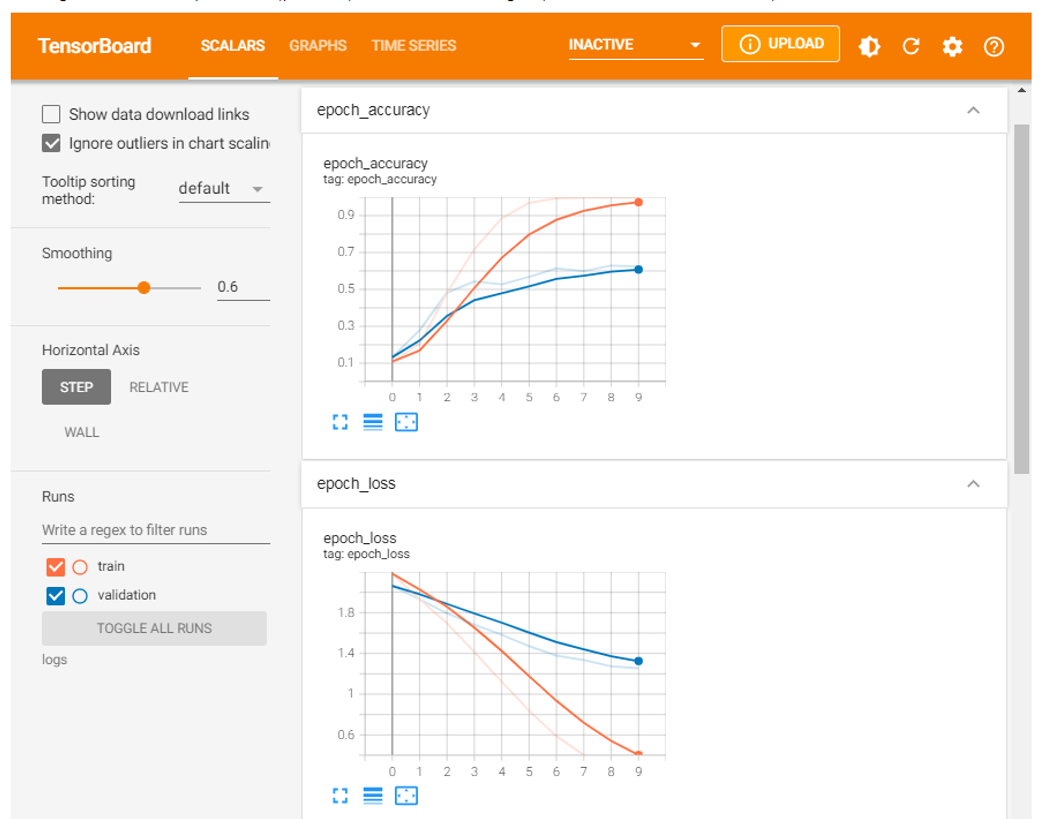

#### iv. Model evaluation

In [497]:
########## Overall accuracy and loss ##########

results=model.evaluate(valid2.batch(20), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

10/10 - 1s - loss: 1.2550 - accuracy: 0.6244
loss: 1.255
accuracy: 0.624


In [498]:
########## Classification report ##########

# Get raw data & its target labels
validation_data, validation_labels = next(iter(valid2.batch(197)))
# Score with model
y_pred=model.predict(validation_data)
# Get overall performance measures
print(classification_report(validation_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        24
           1       0.59      0.40      0.48        25
           2       0.97      0.76      0.85        37
           3       0.94      0.77      0.85        22
           4       0.68      0.53      0.60        32
           5       0.50      0.58      0.54        24
           6       0.31      0.36      0.33        14
           7       0.57      0.42      0.48        19

    accuracy                           0.62       197
   macro avg       0.63      0.60      0.60       197
weighted avg       0.67      0.62      0.63       197



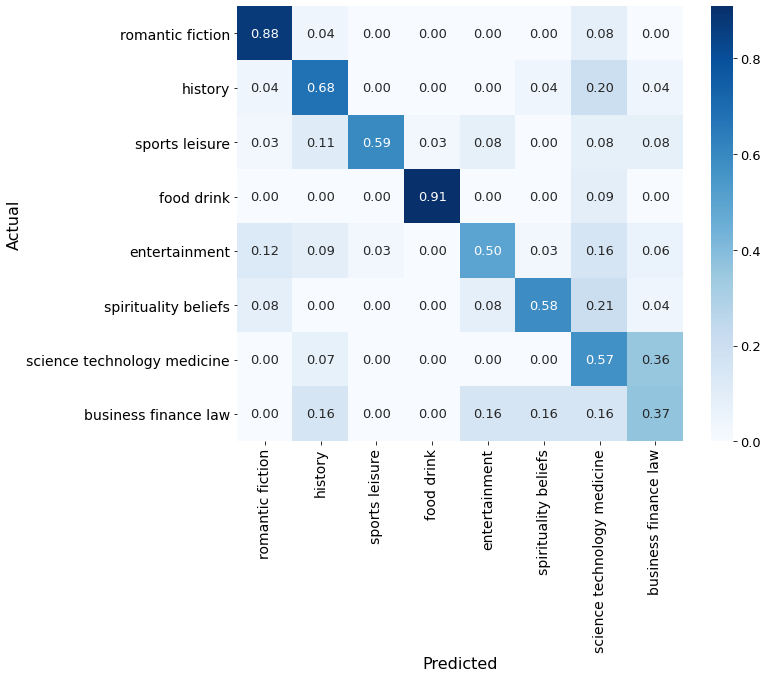

In [206]:
########## Confusion matrix ##########

y_true = validation_labels.numpy().argmax(axis=1)
y_pred = y_pred#.argmax(axis=1)

labels = ['romantic fiction',
          'history',
          'sports leisure',
          'food drink',
          'entertainment',
          'spirituality beliefs',
          'science technology medicine',
          'business finance law']

cm = confusion_matrix(y_true, y_pred)
# Convert nominal values into percentages (of class)
cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams.update({'font.size': 13})
sns.heatmap(cmp, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', size=16)
plt.xlabel('Predicted', size=16)
plt.show(block=False)

The overall performance is lowest in terms of accuracy at 62% and poor rates of successful classification for 5 of the subject categories (<60%).
- The precision & recall statistics are low for 5 subject categories suggesting that the model is creating too many false positives and false negatives, and the F1 scores which are a harmonic mean of these are low as well a result

## 8. Summary of results and conclusion

Since the introduction of NLP early in the DSM020 course I have been intrigued about how powerful it is and how deep the subject matter is. Just touching on it briefly for this project has been an exciting yet challenging journey. 

Three different approaches were undertaken to see how well that could classify books into 8 different subject categories. Immediately after the efforts of CW1 I was convinced that using the highest level subject categories were too broad at that and that the vocabularies for some of the categories, such as 'spirituality beliefs', 'science technology medicine' and 'business finance law' were too similar to be able to create powerful discriminating models. But I persisted as it would be to convenient and misleading to cherry pick more narrowly define categories for the sake of creating a more robust model which would not be complete unless I considered all categories of the level of interest which would expand the task beyond the scope of my current skill level.

The three methods here show solid results especially for the TF-IDF transformation of the unigram and bigram tokens which had an accuracy score of 72% and four of the categories had accuracy rates of over 80% while another two had rates of over 60%. If such a model was implemented by a book cataloguer then they can reduce their manual efforts and focus more on the subject catgories that are more difficult to predict. If we are 

Of course these models could be improved significantly in time with more ML skill being applied. Different classification models could be tried, deep learning in particular. Dimension reduction techniques could also be incorporated. The word embedding approach, which considers semantic aspects of words in a sentence, was dissappointing but this is most probably down to the crude way I implemented it and other factors like the dataset being too small for the embedding vector or not considering the length of the synopses as fixed input lengths allow for the creation of fixed-shape tensors and more stable weights (Ng, 2020). In addition the literature being followed assumed that raw text can be used immediately with the embedding model which in hindsight may have been detrimental.  The model of 'stacked layer' is supposedly a very basic and simple model so perhaps other embedding models could be applied next time. 

By trying multiple approaches in a piecemeal fashion I can created a baseline champion model to see if any of the other two can surpass its peformance. As a matter of fact the baseline model could simply be a classifier that predicted the majority subject category (Zafra, 2019). The majority subject category in my dataset is just over 14% so that would be the accuracy of this classifier. As my best model had an accuracy of 72% then I have achieved an uplift of 5.1 which is pleasing for first attempt. 


## 9. References

DataCamp, 2021, SVM classification with Scikit-learn in Python. [online] available at (https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

Gandler, Gabriela Zarzar, 2020, Training models on imbalanced data. [online] available at https://towardsdatascience.com/training-models-on-imbalanced-data-561fa3f842b5

Geeksforgeeks, 2020, SVM hyperparameter tuning using gridSearchCV. [online] available at https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

Google, 2021, TensorFlow Hub. [online] available at https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2

Kowsari et al, 2019, Text Classification Algorithms: A Survey

Mehmet Baygin, 2018, Classification of Text Documents based on Naïve Bayes using N-Gram Features

Neighbor, Support Vector Machine and Logistic Regression) using Customised Dataset

Ng, 2020, Keras, Tell Me The Genre Of My Book. [online] available at https://towardsdatascience.com/keras-tell-me-the-genre-of-my-book-a417d213e3a1

Ozsarfati et al, 2019, Book Genre Classification Based on Titles with Comparative Machine Learning Algorithms

Parilkumar et al, 2021, Book Genre Categorization Using Machine Learning Algorithms (K-Nearest 

Shikha Gupta et al, 2019, Automated Genre Classification of Books Using Machine Learning and Natural Language Processing

TensorFlow Hub, 2021, Text classification with TensorFlow Hub. [online] available at https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

TowardsDataScience, 2019. [online] available at 'https://towardsdatascience.com/text-classification-in-python-dd95d264c802'

Wikipedia, 2021, Bag of Words model. [online] available at https://en.wikipedia.org/wiki/Bag-of-words_model

Zafra, Miguel Fernandez, 2019, Text Classification in Python. [online] available at 
https://towardsdatascience.com/text-classification-in-python-dd95d264c802


## 10. Create requirements.txt

In [565]:
pip freeze >> requirements.txt

Note: you may need to restart the kernel to use updated packages.
